<p style="float:right"> <img src="assets/orange.png" alt="Orange logo" width="40" /> <img src="assets/ulb.jpg" alt="ULB logo" width="40" /> <img src="assets/mlg.png" alt="MLG logo" width="160" /> <img src="assets/innoviris.jpg" alt="Innoviris logo" width="200" /></p>

**_Notebook for the project Machu-Picchu written by Théo Verhelst_**<br/>
_Supervisors at Orange: Denis Mercier, Jeevan Shrestha_<br/>
_Academic supervision: Gianluca Bontempi (ULB MLG)_
# Estimation of the probability of counterfactuals from real data

In [1]:
library(caret) # createFolds
library(ggplot2)
library(reshape2)
library(uplift)
source("utils.R")
source("estimate_cf.R")

Loading required package: ggplot2

Loading required package: lattice

Loading required package: RItools

Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve


Loading required package: MASS

Loading required package: coin

Loading required package: survival


Attaching package: ‘survival’


The following object is masked from ‘package:caret’:

    cluster


Loading required package: tables

Loading required package: penalized

Welcome to penalized. For extended examples, see vignette("penalized").



In [2]:
data <- read.csv("orange_churn.csv")
data <- list(
    x = remove_columns(data, c("y", "t")),
    y = data$y,
    t = data$t
)

In [3]:
S_0 <- mean(data$y[data$t == "0"] == "1")
S_1 <- mean(data$y[data$t == "1"] == "1")

In [4]:
cat("S_0 = ", S_0, "\n")
cat("S_1 = ", S_1, "\n")
cat("P(T=1) = ", mean(data$t == "1"), "\n")
cat("N = ", nrow(data$x), "\n")
cat("N_features = ", ncol(data$x), "\n")

S_0 =  0.05038335 
S_1 =  0.04347826 
P(T=1) =  0.5894784 
N =  2224 
N_features =  137 


In [5]:
bounds <- frechet_bounds(S_0, S_1)

In [6]:
bounds

$alpha
$alpha$min
[1] 0.9061384

$alpha$max
[1] 0.9496166


$beta
$beta$min
[1] 0.006905091

$beta$max
[1] 0.05038335


$gamma
$gamma$min
[1] 0

$gamma$max
[1] 0.04347826


$delta
$delta$min
[1] 0

$delta$max
[1] 0.04347826


$phi
$phi$min
[1] -0.002190581

$phi$max
[1] 0.04128768

In [8]:
results <- readRDS("runs/results_uplift_rf.rds")

In [9]:
cat("hat S_0 = ", mean(results$pred$S_0) * 100, "%\n")
cat("hat S_1 = ", mean(results$pred$S_1) * 100, "%\n")
cat("S_0 = ", mean(results$pred$y[results$pred$t == "0"] == "1") * 100, "%\n")
cat("S_1 = ", mean(results$pred$y[results$pred$t == "1"] == "1") * 100, "%\n")

cat("initial prior = ", mean(results$pred$S_0) * 100, "%\n")
cat("resulting prior = ", mean(calibrate_score(results$pred$S_0, mean(results$pred$y[results$pred$t == "0"] == "1"))) * 100, "%\n")

hat S_0 =  5.066484 %
hat S_1 =  4.354319 %
S_0 =  5.038335 %
S_1 =  4.347826 %
initial prior =  5.066484 %
resulting prior =  5.038991 %


# Plot the bounds on the probability of counterfactuals

In [12]:
var_suf <- c("ind", "lb_s_ind", "ub_s_ind", "lb_s_pop", "ub_s_pop")

results_melted <- data.frame()
for (var_pre in c("alpha", "beta", "gamma", "delta")) {
    rows <- data.frame(var = var_pre)
    rows[,var_suf] <- results$stats[,paste0(var_pre, "_", var_suf)]
    results_melted <- as.data.frame(rbind(results_melted, rows))
}


In [13]:
results_melted

var,ind,lb_s_ind,ub_s_ind,lb_s_pop,ub_s_pop
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
alpha,0.908328039,0.905791974,0.94193306,0.906138388,0.94961665
beta,0.048128771,0.014523755,0.05066484,0.006905091,0.05038335
gamma,0.041007125,0.007402108,0.04354319,0.000000000,0.04347826
delta,0.002536065,0.000000000,0.03614108,0.000000000,0.04347826


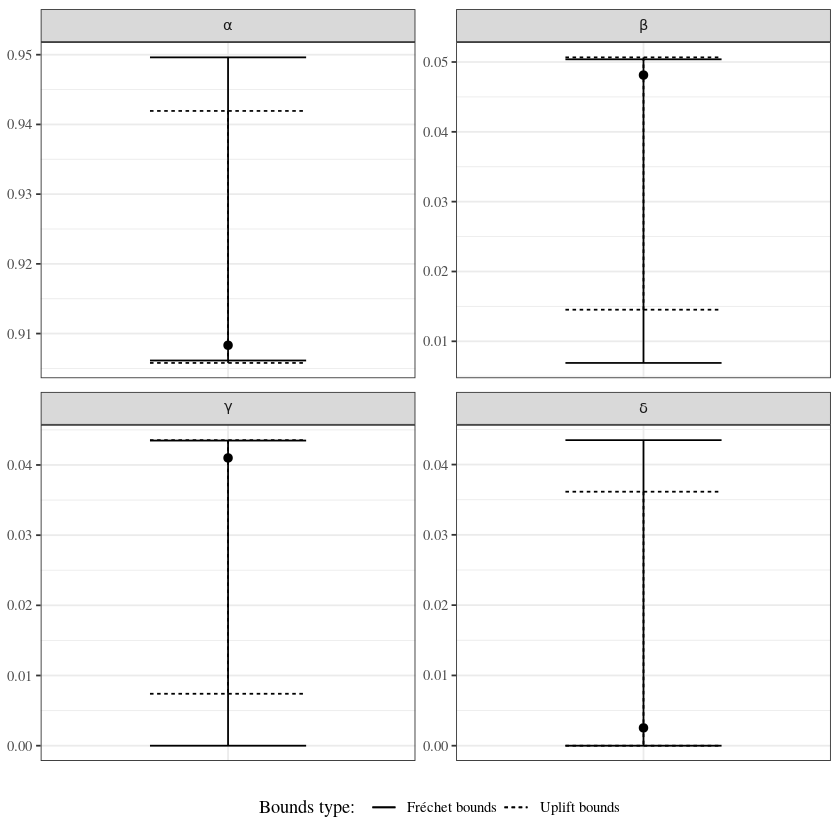

In [14]:
plot_width <- 14
plot_height <- 10
plot_units <- "cm"
font_size <- 11
font_family <- "Times"

p <- ggplot(results_melted) +
  geom_point(aes(x = var, y = ind), size=2) +
  geom_errorbar(aes(x = var, ymin = lb_s_ind, ymax = ub_s_ind, linetype = "Uplift bounds"), width=0.5) +
  geom_errorbar(aes(x = var, ymin = lb_s_pop, ymax = ub_s_pop, linetype = "Fréchet bounds"), width=0.5) +
facet_wrap(~factor(var, levels=c("alpha", "beta", "gamma", "delta")), scales="free", labeller = label_parsed) +
  labs(x = NULL, y = NULL, linetype="Bounds type:") +
  scale_x_discrete(labels=NULL) +
  theme_bw() +
  theme(
    text = element_text(size = font_size, family = font_family),
    legend.position="bottom",
    axis.ticks.x = element_blank()
  )
p
#ggsave("pdf/emp_bounds.pdf", plot = p, width = plot_width, height = 0.7 * plot_height, units = plot_units)

In [15]:
format(t(results_melted[-1]) * 100, digits=2)

ind,90.83,4.81,4.10,0.25
lb_s_ind,90.58,1.45,0.74,0.00
ub_s_ind,94.19,5.07,4.35,3.61
lb_s_pop,90.61,0.69,0.00,0.00
ub_s_pop,94.96,5.04,4.35,4.35


In [16]:
head(results_melted)

,var,ind,lb_s_ind,ub_s_ind,lb_s_pop,ub_s_pop
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,alpha,0.908328039,0.905791974,0.94193306,0.906138388,0.94961665
2,beta,0.048128771,0.014523755,0.05066484,0.006905091,0.05038335
3,gamma,0.041007125,0.007402108,0.04354319,0.000000000,0.04347826
4,delta,0.002536065,0.000000000,0.03614108,0.000000000,0.04347826


In [17]:
vars <- c("alpha", "beta", "gamma", "delta")
get_val <- function(var, col)
    format(results_melted[results_melted[,"var"] == var, col] * 100, digits=4)

cat("Point estimate & ",   paste0(sapply(vars, function(var) paste0("$", get_val(var, "ind"), "$")), collapse = " & "), "\\\\\n")
cat("ML bounds      & ", paste0(sapply(vars, function(var) paste0("$[", get_val(var, "lb_s_ind"), ",", get_val(var, "ub_s_ind"), "]$")), collapse = " & "), "\\\\\n")
cat("Fréchet bounds & ", paste0(sapply(vars, function(var) paste0("$[", get_val(var, "lb_s_pop"), ",", get_val(var, "ub_s_pop"), "]$")), collapse = " & "), "\\\\\n")

Point estimate &  $90.83$ & $4.813$ & $4.101$ & $0.2536$ \\
ML bounds      &  $[90.58,94.19]$ & $[1.452,5.066]$ & $[0.7402,4.354]$ & $[0,3.614]$ \\
Fréchet bounds &  $[90.61,94.96]$ & $[0.6905,5.038]$ & $[0,4.348]$ & $[0,4.348]$ \\
